# Trabalho Prático 1


## Grupo 04 - Renato Garcia (A101987) & Bernardo Moniz (A102497)

## Problema 2
### Enunciado


2.  Um sistema de tráfego  é representado por um grafo orientado ligado. Os nodos denotam pontos de acesso e  os arcos denotam vias de comunicação só com um sentido . O grafo tem de ser ligado: entre cada par de nodos $\langle n_1,n_2 \rangle$ tem de existir um caminho $n_1 \leadsto n_2$ e um caminho $n_2\leadsto n_1$.


    a. Gerar aleatoriamente o grafo com  $N \in\{6..10\}$  nodos e com ramos verificando:    
        i. Cada nodo tem um número aleatório de descendentes $d \in\{1..3\}$ cujos destinos são também gerados aleatoriamente.   
        ii. Se  existirem “loops” ou destinos repetidos, deve-se gerar outro grafo.
    

    b. Pretende-se fazer  manutenção interrompendo  determinadas vias. Determinar o maior número de vias que é possível remover mantendo o grafo ligado.


### Resolução

Para se verificar que em um grafo cada par de nodos $\langle n_1,n_2 \rangle$ existe um caminho $n_1 \leadsto n_2$ e um caminho $n_2\leadsto n_1$, primeiramente o que fazemos é criar um grafo cíclico orientado, com nodos entre 6 a 10. 

De seguida, para cada nodo adicionamos um número aleatório de descendentes, de 0 a 2, uma vez que ao criar o grafo cíclico já estamos a usar 1 descendente em cada nodo.

Após criar os descendentes para cada nodo, garantimos que não há "loops".

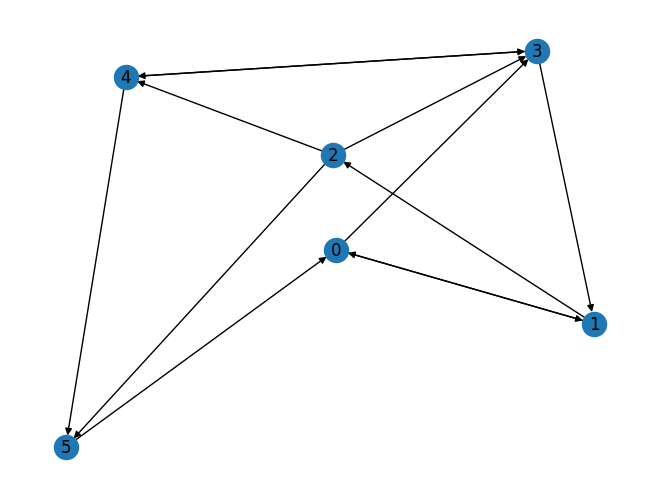

In [1]:
import networkx as nx
import random

def gerar_grafo_fortemente_conexo():
    N = random.randint(6, 10)
    G = nx.cycle_graph(N, create_using=nx.DiGraph())

    for node in G.nodes:
        num_descendentes = random.randint(0, 2)
        descendentes = random.sample(range(N), num_descendentes) 

        for d in descendentes:
            if node != d and not G.has_edge(node, d):
                G.add_edge(node, d)

    return G

G1 = gerar_grafo_fortemente_conexo()
nx.draw(G1, with_labels=True)

Para fazer a manutenção, remover o maior número de vias possíveis ao manter o grafo ligado, começamos por inicializar as arestas e os caminhos.

Posteriormente, colocamos uma restrição de que se o caminho é preservado então todas as arestas que o compõem também são preservadas.

Além disso, outra restrição é garantir que pelo menos um caminho entre pares de nodos é preservado.

Por fim, minimizamos as arestas, ou seja, removemos as arestas que não são necessárias para manter o grafo ligado.

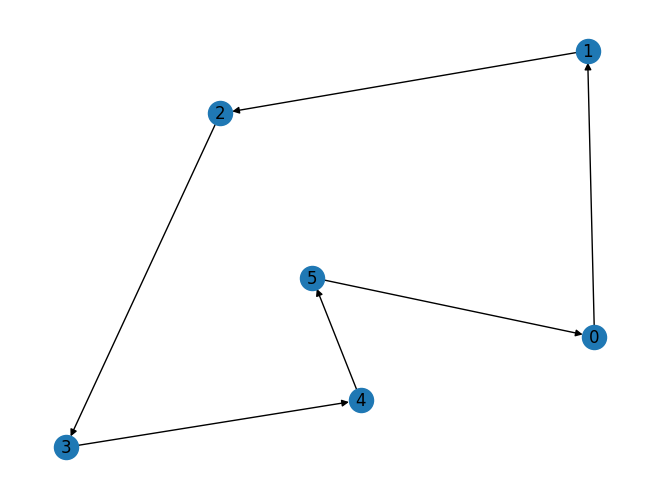

In [2]:
from ortools.linear_solver import pywraplp

def manutencao_de_vias(G):
    solver = pywraplp.Solver.CreateSolver("SCIP")
    A = {}  # arestas
    C = {}  # caminhos
    
    # Inicialização de variáveis
    for u, v in G.edges:
        A[(u, v)] = solver.IntVar(0, 1, f'A_{u}_{v}')
    
    for o in G.nodes:
        for d in G.nodes:
            if o != d:
                C[(o, d)] = {}
                for c in nx.shortest_simple_paths(G, o, d):
                    C[(o, d)][tuple(c)] = solver.IntVar(0, 1, f'C_{o}_{d}_{c}')
                    
                    # Restrição: se o caminho for preservado (C[(o, d)][c] = 1), 
                    # então todas as arestas do caminho têm de ser preservadas (A[(u, v)] = 1)
                    for i in range(len(c) - 1):
                        u, v = c[i], c[i+1]
                        solver.Add(C[(o, d)][tuple(c)] <= A[(u, v)])

    # Restrição: garantir que pelo menos um caminho entre o e d é preservado
    for o in G.nodes:
        for d in G.nodes:
            if o != d:
                solver.Add(solver.Sum([C[(o, d)][c] for c in C[(o, d)]]) >= 1)


    # Minimizar o número de arestas utilizadas
    solver.Minimize(solver.Sum([A[(u, v)] for u, v in G.edges()])) 
    
    
    status = solver.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        arestas_preservadas = []
        for u, v in G.edges:
            if A[(u, v)].solution_value() == 1:
                arestas_preservadas.append((u, v))
            
    G_preservado = nx.DiGraph()
    G_preservado.add_nodes_from(G.nodes)
    G_preservado.add_edges_from(arestas_preservadas)

    return G_preservado

G2 = manutencao_de_vias(G1)
nx.draw(G2, with_labels=True)